### Notebook to train `FPN` on `iMaterialist` dataset

In [1]:
import os
import json
import numpy as np
import pandas as pd

from PIL import Image
import cv2

from io_utils import load_json

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 0. Explore `train.csv` and make familiar with `data`

In [2]:
DATA_PATH = './data/'
CSV_PATH = os.path.join(DATA_PATH, 'train.csv')
META_PATH = os.path.join(DATA_PATH, 'label_descriptions.json')
IMAGE_PATH = os.path.join(DATA_PATH, 'train_resized/')

### `train.csv`

In [3]:
df = pd.read_csv(CSV_PATH)
print('Shape: ', df.shape)
df.head()

Shape:  (331213, 5)


,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [4]:
print('# of unique images: ', df['ImageId'].unique().shape[0])
print('\n# of unique ClassId: ', df['ClassId'].unique().shape[0])
print('ClassId is pair of category+attribute')

# of unique images:  45195

# of unique ClassId:  6354
ClassId is pair of category+attribute


### `dataset metadata`

In [5]:
label_descriptions = load_json(META_PATH)

In [6]:
for k, v in label_descriptions.items():
    print(k)

info
categories
attributes


**categories**

In [7]:
cat_ids = []
cat_names = []
cat_supercats = []
cat_levels = []

for cat in label_descriptions['categories']:
    cat_ids.append(cat['id'])
    cat_names.append(cat['name'])
    cat_supercats.append(cat['supercategory'])
    cat_levels.append(cat['level'])

print('# of unique categories: \t', np.unique(cat_ids).shape[0])
print('# of unique names: \t\t', np.unique(cat_names).shape[0])
print('# of unique supercategories: \t',np.unique(cat_supercats).shape[0])
print('# of unique levels: \t\t', np.unique(cat_levels).shape[0])

meta_df = pd.DataFrame(data={
    'id': cat_ids,
    'cat_name': cat_names,
    'cat_super': cat_supercats
})

# of unique categories: 	 46
# of unique names: 		 46
# of unique supercategories: 	 12
# of unique levels: 		 1


In [8]:
print(meta_df['cat_name'].unique())

['shirt, blouse' 'top, t-shirt, sweatshirt' 'sweater' 'cardigan' 'jacket'
 'vest' 'pants' 'shorts' 'skirt' 'coat' 'dress' 'jumpsuit' 'cape'
 'glasses' 'hat' 'headband, head covering, hair accessory' 'tie' 'glove'
 'watch' 'belt' 'leg warmer' 'tights, stockings' 'sock' 'shoe'
 'bag, wallet' 'scarf' 'umbrella' 'hood' 'collar' 'lapel' 'epaulette'
 'sleeve' 'pocket' 'neckline' 'buckle' 'zipper' 'applique' 'bead' 'bow'
 'flower' 'fringe' 'ribbon' 'rivet' 'ruffle' 'sequin' 'tassel']


In [9]:
print(meta_df['cat_super'].unique())

['upperbody' 'lowerbody' 'wholebody' 'head' 'neck' 'arms and hands'
 'waist' 'legs and feet' 'others' 'garment parts' 'closures' 'decorations']


In [10]:
meta_df

,id,cat_name,cat_super
0,0,"shirt, blouse",upperbody
1,1,"top, t-shirt, sweatshirt",upperbody
2,2,sweater,upperbody
3,3,cardigan,upperbody
4,4,jacket,upperbody
5,5,vest,upperbody
6,6,pants,lowerbody
7,7,shorts,lowerbody
8,8,skirt,lowerbody
9,9,coat,wholebody


### !!! IMPORTANT: take only integral part of clothes == `.iloc[:27]`

In [11]:
# meta_df = meta_df.iloc[:27]
meta_df = meta_df.iloc[:3]
N_CLASSES = len(meta_df)
print(N_CLASSES)

3


**attributes**

In [12]:
ids = []
names = []
supercats = []
levels = []

for cat in label_descriptions['attributes']:
    ids.append(cat['id'])
    names.append(cat['name'])
    supercats.append(cat['supercategory'])
    levels.append(cat['level'])

print('# of unique categories: \t', np.unique(ids).shape[0])
print('# of unique names: \t\t', np.unique(names).shape[0])
print('# of unique supercategories: \t',np.unique(supercats).shape[0])
print('# of unique levels: \t\t', np.unique(levels).shape[0])

# of unique categories: 	 92
# of unique names: 		 92
# of unique supercategories: 	 7
# of unique levels: 		 2


In [13]:
print(np.unique(supercats))

['animal' 'length' 'opening type' 'silhouette'
 'textile finishing, manufacturing techniques' 'textile pattern'
 'waistline']


In [14]:
print(np.unique(names))

['a-line' 'above-the-hip (length)' 'above-the-knee (length)' 'abstract'
 'argyle' 'asymmetrical' 'baggy' 'balloon' 'basque (wasitline)' 'bell'
 'bell bottom' 'below the knee (length)' 'bootcut' 'buckled (opening)'
 'burnout' 'camouflage' 'cartoon' 'check' 'cheetah' 'chevron' 'circle'
 'curved (fit)' 'cutout' 'distressed' 'dot' 'double breasted'
 'dropped waistline' 'embossed' 'empire waistline' 'fair isle'
 'fit and flare' 'flare' 'floor (length)' 'floral' 'fly (opening)'
 'frayed' 'gathering' 'geometric' 'giraffe' 'herringbone (pattern)'
 'high low' 'high waist' 'hip (length)' 'houndstooth (pattern)'
 'knee (length)' 'lace up' 'leopard' 'letters, numbers' 'lining'
 'loose (fit)' 'low waist' 'maxi (length)' 'mermaid' 'micro (length)'
 'midi' 'mini (length)' 'no opening' 'no special manufacturing technique'
 'no waistline' 'normal waist' 'oversized' 'paisley' 'peacock' 'peg'
 'pencil' 'peplum' 'perforated' 'plain (pattern)' 'plant' 'pleat'
 'printed' 'quilted' 'regular (fit)' 'ruched' '

### 1. Preprocess data

In [15]:
# extract categories, since classid is a concatenation of cat_att1_att2_..._attN
df['CategoryId'] = df['ClassId'].str.split('_').str[0].astype(int)

In [16]:
# slice for selected classes
df = df[df['CategoryId'].isin(meta_df['id'])]

In [17]:
# Rows with the same image are grouped together because the subsequent operations perform at an image level
image_df = df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = df.groupby('ImageId')['Height', 'Width'].first()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", image_df.shape)
image_df.head()

Total images:  (22694, 4)


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6323163 11 6328356 32 6333549 53 6338742 75 6...,[0],5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[1343707 9 1346138 27 1348569 44 1351000 62 13...,[1],2448,2448
00048c3a2fb9c29340473c4cfc06424a.jpg,[257702 10 258670 26 259640 36 260572 6 260610...,[1],975,650
0006ea84499fd9a06fefbdf47a5eb4c0.jpg,[73327 6 74328 18 75330 37 76335 63 77340 88 7...,[1],1000,667
000775b6b5e27b011dc8bba2d7b85211.jpg,[309670 11 311259 33 312848 55 314440 72 31603...,[1],1600,1067


## 2. EDA

<Figure size 1080x504 with 0 Axes>

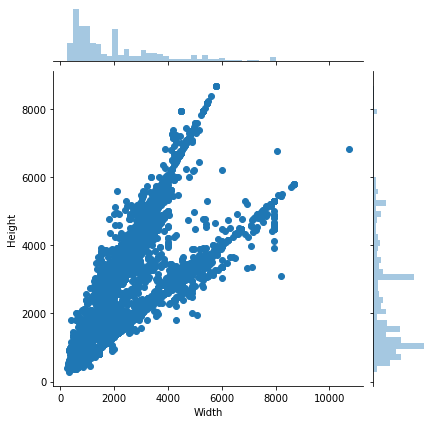

In [18]:
plt.figure(figsize=(15, 7))
sns.jointplot(x=image_df['Width'], y=image_df['Height'])

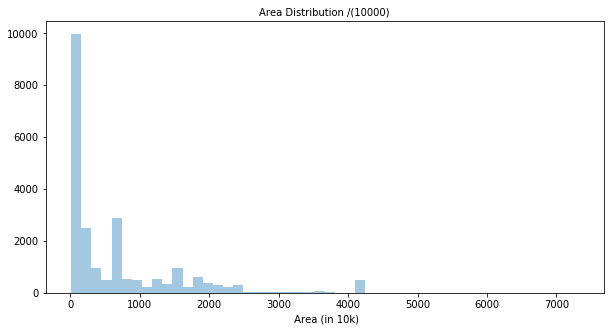

In [19]:
plt.figure(figsize=(10, 5))
sns.distplot((image_df['Height'] * image_df['Width'])/10000, kde=False);
plt.title("Area Distribution /(10000)", fontsize=10)
plt.xlabel(" Area (in 10k)", fontsize=10)
plt.show()

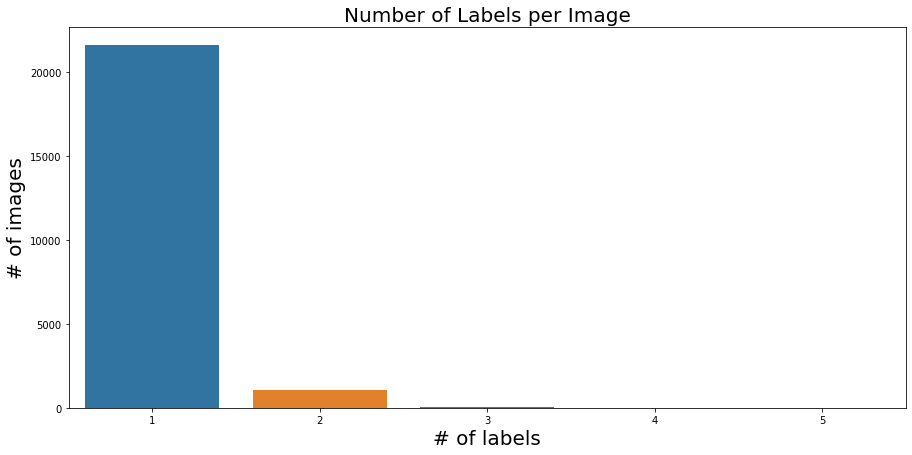

In [20]:
# number of labels per image
labels_per_image = image_df['CategoryId'].map(lambda x:len(x)).value_counts().to_frame().reset_index().sort_values(by = 'index')
labels_per_image.columns = ['#labels','#images']

plt.figure(figsize=(15, 7))
sns.barplot(labels_per_image['#labels'],labels_per_image['#images'])
plt.title("Number of Labels per Image", fontsize=20)
plt.xlabel("# of labels", fontsize=20)
plt.ylabel("# of images", fontsize=20)
plt.show()

In [21]:
df_aux = df.merge(meta_df, left_on='CategoryId', right_on='id')
df_aux = df_aux.groupby('cat_name')['ImageId'].nunique().to_frame().reset_index()
df_aux.head()

,cat_name,ImageId
0,"shirt, blouse",6088
1,sweater,1474
2,"top, t-shirt, sweatshirt",15860


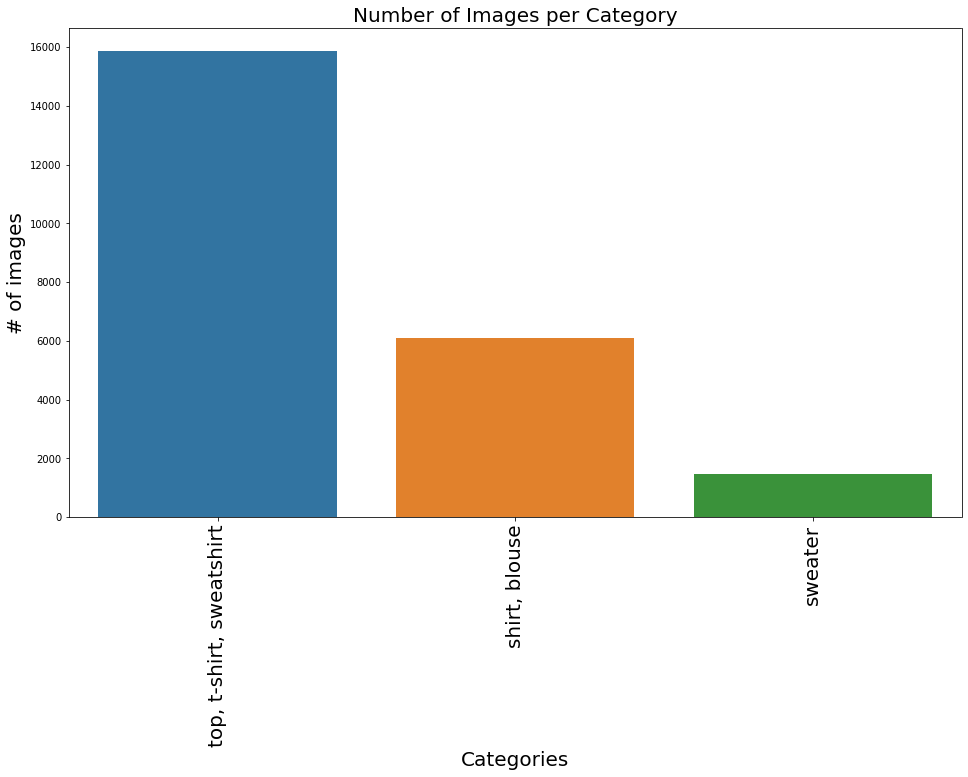

In [22]:
df_aux = df_aux.sort_values('ImageId', ascending=False)
plt.figure(figsize=(16,9))
sns.barplot(x='cat_name', y='ImageId', data=df_aux)
plt.xticks(rotation=90, fontsize=20)
plt.title("Number of Images per Category", fontsize=20)
plt.xlabel("Categories", fontsize=20)
plt.ylabel("# of images", fontsize=20)
plt.show()

## 3. Build dataset

In [23]:
# check loaded images

images = os.listdir(IMAGE_PATH)
uploaded_images = pd.DataFrame(images, columns = ['image_name'])
assert np.alltrue(image_df.index.isin(uploaded_images['image_name']))

#### Train / test split

In [24]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(image_df, test_size=0.05, shuffle=True, random_state=1337)

train_df = train_df.sample(3000)

print('Train size: \t', train_df.shape[0])
print('Test size: \t', test_df.shape[0])

Train size: 	 3000
Test size: 	 1135


In [25]:
# from loaders import ???
from datasets import iMaterialistDataset

IMAGE_SIZE = 512 

In [26]:
from utils import visualize

def vis(image, mask, meta_df):
    for ix, k in enumerate(meta_df['cat_name']):
        m = mask[..., ix]
        if np.sum(m) > 0:
            visualize(
                image=image, 
                **{k:m}
            )

Plotting sample images:


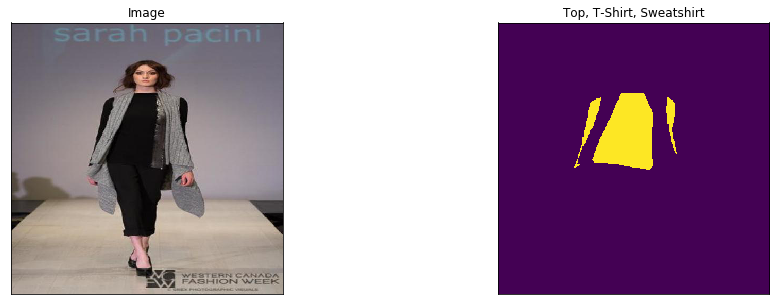

Plotting augmented images:

0-th image..



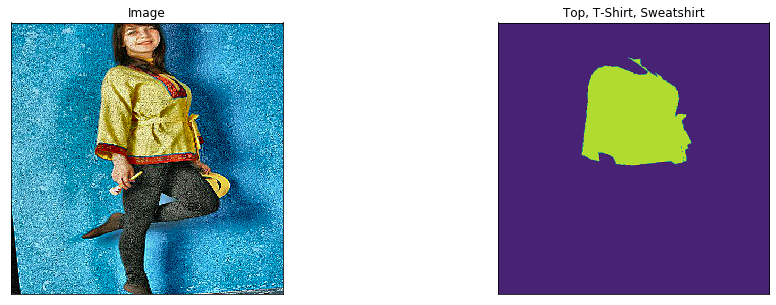


1-th image..



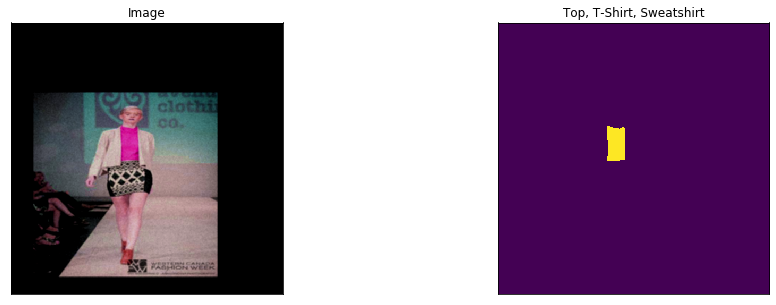


2-th image..



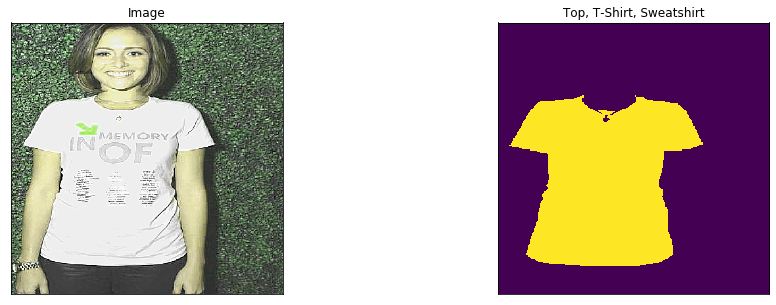


3-th image..



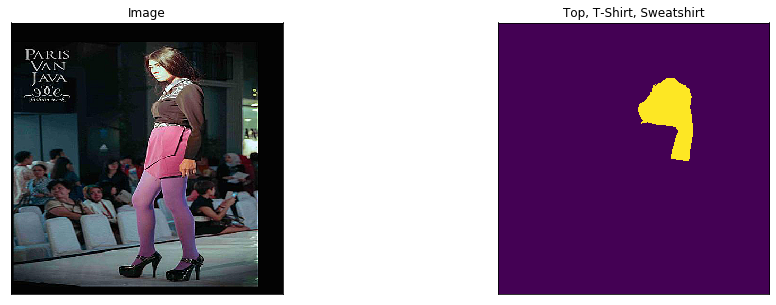


4-th image..



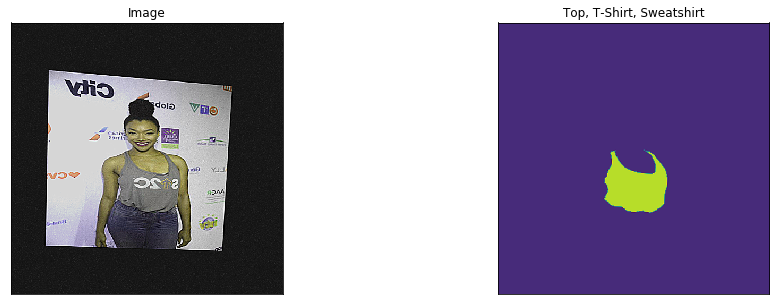


5-th image..



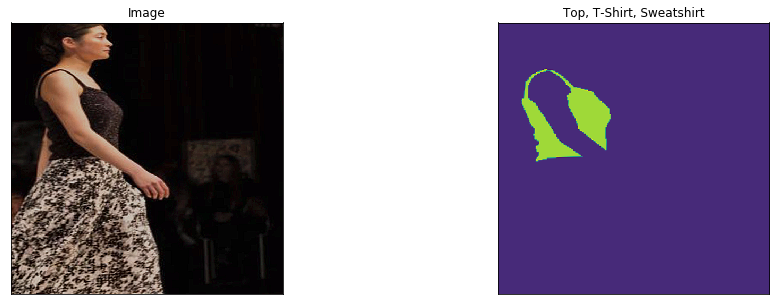


6-th image..



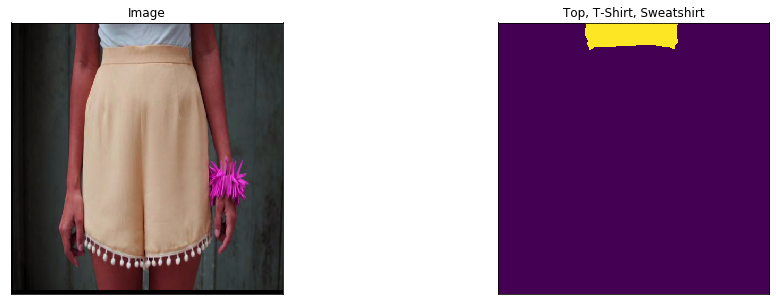


7-th image..



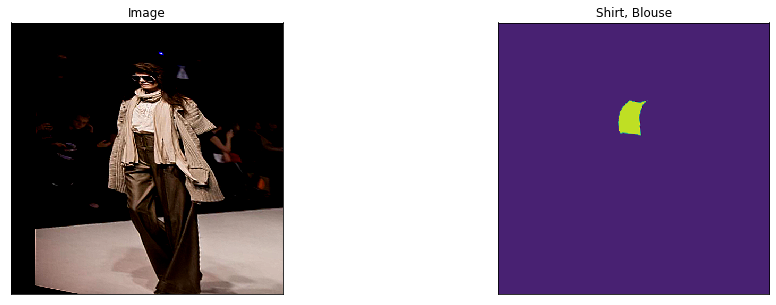


8-th image..



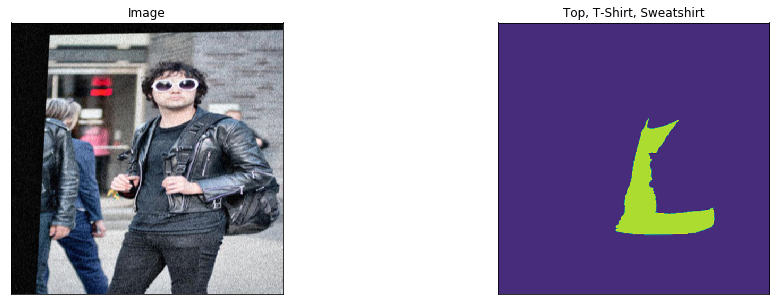


9-th image..



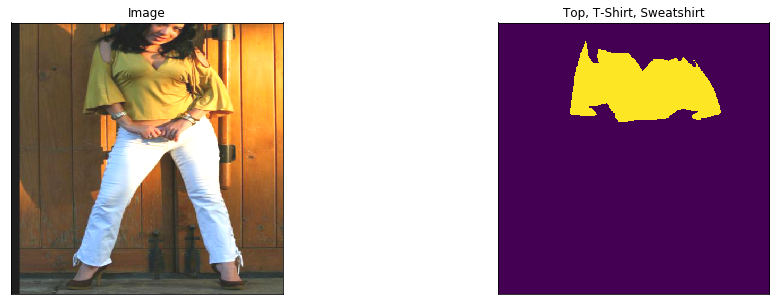

In [27]:
from preprocessing import get_training_augmentation, get_validation_augmentation, get_preprocessing

print('Plotting sample images:')
dataset = iMaterialistDataset(test_df, meta_df, img_dir=IMAGE_PATH, img_size=IMAGE_SIZE)
image, mask = dataset[3] # get some sample

vis(image, mask, meta_df)

print('Plotting augmented images:')
augmented_dataset = iMaterialistDataset(
    train_df, meta_df,img_dir=IMAGE_PATH,
    augmentation=get_training_augmentation(IMAGE_SIZE, IMAGE_SIZE)
)

# same image with different random transforms
for i in range(10):
    print(f'\n{i}-th image..\n')
    image, mask = augmented_dataset[i]
    vis(image, mask, meta_df)

### 3. Train model

In [28]:
import torch
from torch.utils.data import DataLoader
import albumentations as albu
import segmentation_models_pytorch as smp
from preprocessing import get_training_augmentation, get_validation_augmentation, get_preprocessing

In [41]:
# ENCODER = 'resnext50_32x4d'
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'  # could be None for logits or 'softmax2d' for multiclass segmentation

In [42]:
# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=N_CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/yv.shmulev/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [43]:
EXP_NAME = 'ten_class_experiment'

exp_path = os.path.join('./experiments/', EXP_NAME)
if not os.path.exists(exp_path):
    os.mkdir(exp_path)
    
print('Experiment path: ', exp_path)

model_path = os.path.join(exp_path, 'models/')

try:
    os.mkdir(model_path)
except FileExistsError:
    pass

Experiment path:  ./experiments/ten_class_experiment


In [44]:
train_dataset = iMaterialistDataset(
    train_df, meta_df, img_dir=IMAGE_PATH,
    augmentation=get_training_augmentation(IMAGE_SIZE, IMAGE_SIZE), 
    preprocessing=get_preprocessing(preprocessing_fn)
)


valid_dataset = iMaterialistDataset(
    test_df, meta_df, img_dir=IMAGE_PATH,
    augmentation=get_validation_augmentation(IMAGE_SIZE, IMAGE_SIZE), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

In [46]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [35]:
LEARNING_RATE = 1e-4

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

In [39]:
DEVICE = 'cuda:1'

# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [40]:
N_EPOCHS = 40

max_score = 0
best_epoch = 0
for i_epoch in range(0, N_EPOCHS):

    print('\nEpoch: {}'.format(i_epoch))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(model_path, f'model_{i_epoch}.pth'))
        best_epoch = i_epoch
        print('Model saved to ', os.path.join(model_path, f'model_{i_epoch}.pth'))

    if i_epoch == 25:
        optimizer.param_groups[0]['lr'] = LEARNING_RATE / 10
        print(f'Decrease decoder learning rate to {LEARNING_RATE / 10}')

print(f'Best epoch: {best_epoch}')


Epoch: 0
valid: 100%|██████████| 284/284 [00:27<00:00, 10.33it/s, dice_loss - 0.8749, iou_score - 0.0709] 
Model saved to  ./experiments/ten_class_experiment/models/model_0.pth

Epoch: 1
valid: 100%|██████████| 284/284 [00:27<00:00, 10.26it/s, dice_loss - 0.8749, iou_score - 0.0709] 

Epoch: 2
valid: 100%|██████████| 284/284 [00:27<00:00, 10.24it/s, dice_loss - 0.8749, iou_score - 0.0709] 

Epoch: 3
valid: 100%|██████████| 284/284 [00:27<00:00, 10.27it/s, dice_loss - 0.8749, iou_score - 0.0709] 

Epoch: 4
valid: 100%|██████████| 284/284 [00:27<00:00, 10.25it/s, dice_loss - 0.8749, iou_score - 0.0709] 

Epoch: 5
train:  15%|█▍        | 28/188 [00:42<04:00,  1.51s/it, dice_loss - 0.8523, iou_score - 0.08065]


KeyboardInterrupt: 

In [ ]:
# from tqdm import tqdm_notebook

# IMAGE_PATH_NEW = os.path.join(DATA_PATH, 'train_resized')

# errors = []
# print('old path: ', IMAGE_PATH)
# print('new path: ', IMAGE_PATH_NEW)

# for img_path in tqdm_notebook(image_df.index):
#     img = np.array(Image.open(os.path.join(IMAGE_PATH, img_path)))
#     img_r = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
#     if len(img_r.shape) < 3:
#         img_r = cv2.cvtColor(img_r,cv2.COLOR_GRAY2RGB)
#         print(img_path)
#         errors.append(img_path)
#     Image.fromarray(img_r).save(os.path.join(IMAGE_PATH_NEW, img_path))
    
            

In [54]:
best_epoch = 30
# load best saved checkpoint
best_model = torch.load(os.path.join('./experiments/one_class_shirt/models/', f'model_{best_epoch}.pth'))

### 5. Model evaluation

In [55]:
# create test dataset
test_dataset = iMaterialistDataset(
    test_df, meta_df.iloc[:1], img_dir=IMAGE_PATH,
    augmentation=get_validation_augmentation(IMAGE_SIZE, IMAGE_SIZE), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [56]:
# create vis dataset
test_dataset_vis = iMaterialistDataset(
    test_df, meta_df.iloc[:1], img_dir=IMAGE_PATH,
    augmentation=get_validation_augmentation(IMAGE_SIZE, IMAGE_SIZE), 
    # preprocessing=get_preprocessing(preprocessing_fn),
)

In [57]:
from utils import predict_mask_from_raw

In [74]:
m = predict_mask_from_raw(np.array(Image.open(os.path.join(IMAGE_PATH, test_df.index[0]))), best_model,
                      activation=None, device=DEVICE)
# torch.nn.Softmax2d()

In [75]:
np.array(Image.open(os.path.join(IMAGE_PATH, test_df.index[0]))).shape

(512, 512, 3)

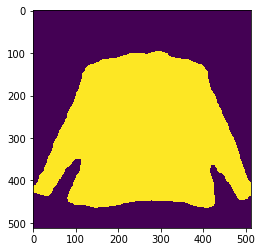

In [76]:
plt.imshow(m)

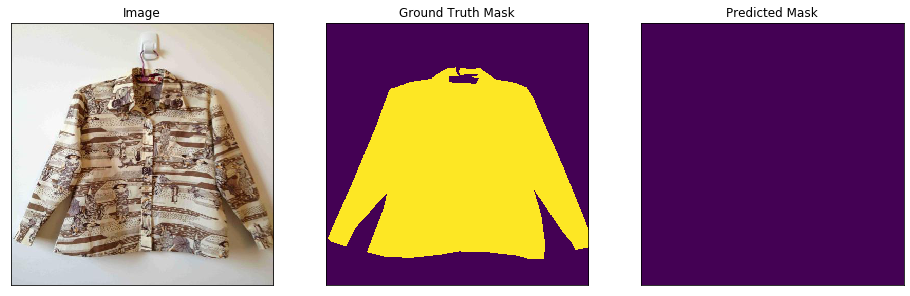

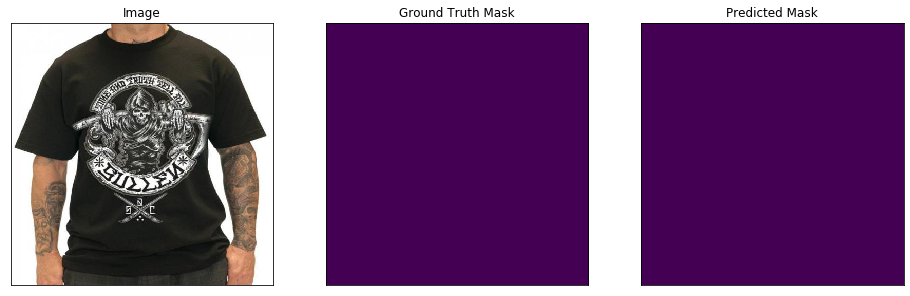

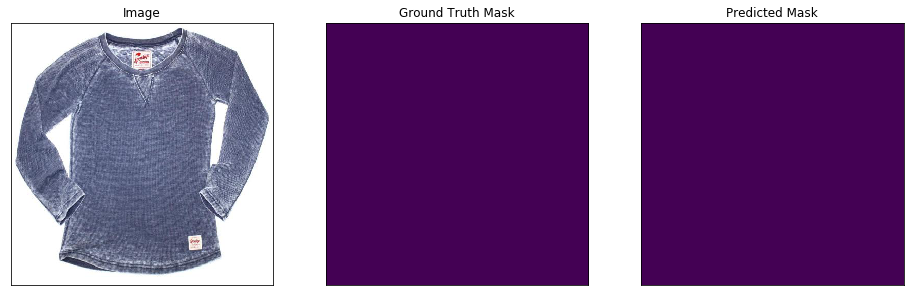

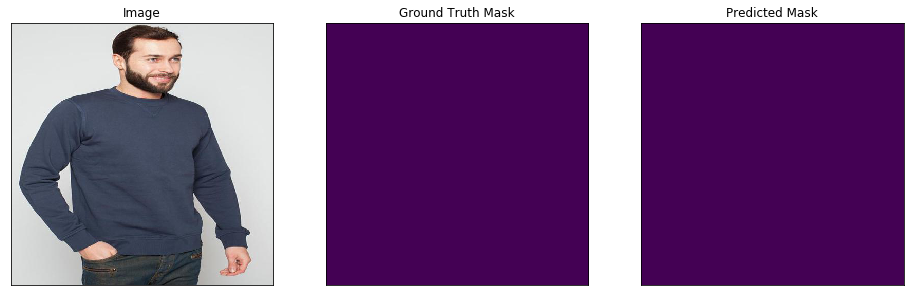

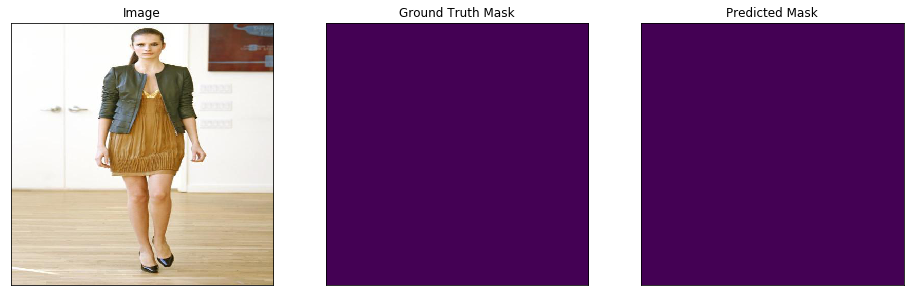

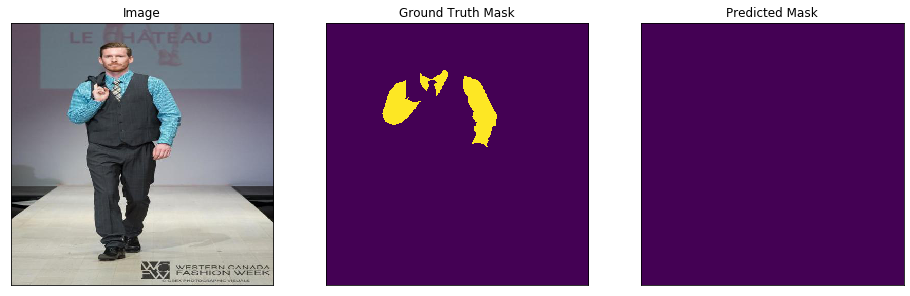

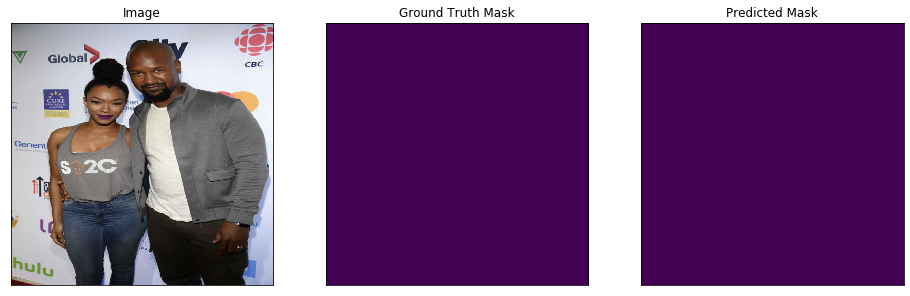

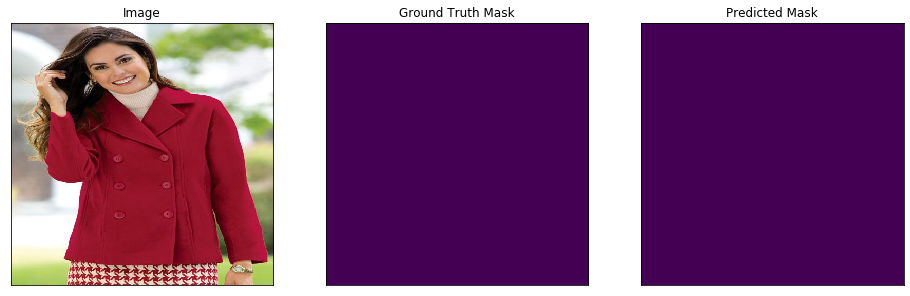

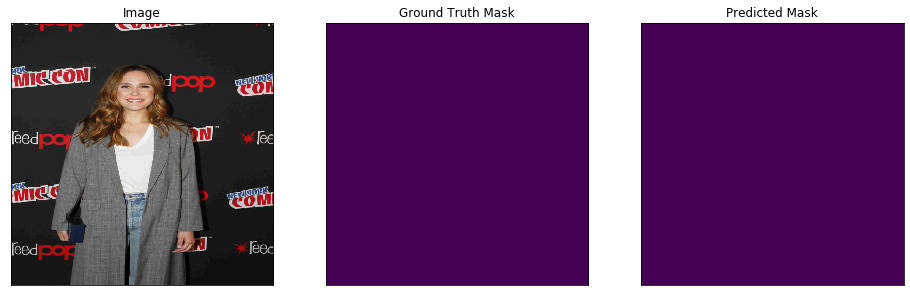

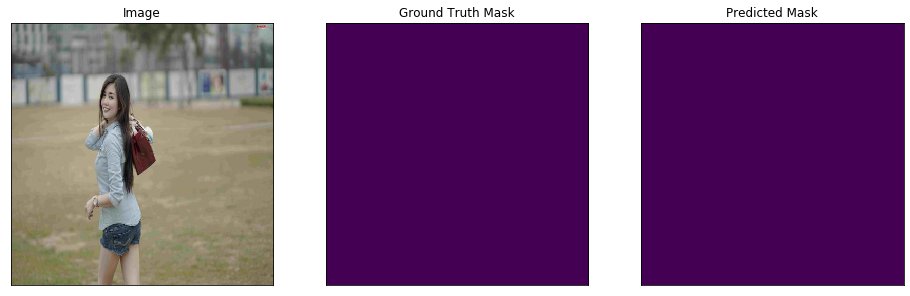

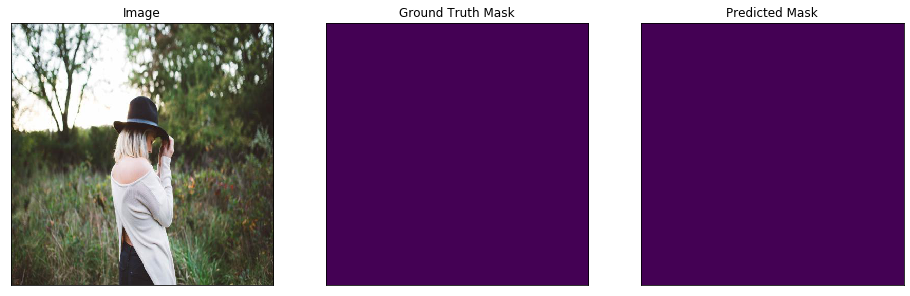

In [48]:
from predict import predict_mask

best_model.to(DEVICE)

for i in range(len(test_dataset_vis)):
    if i > 10:
        break
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    pr_mask = predict_mask(image, best_model)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[0, ...], 
        predicted_mask=pr_mask[0, ...]
    )

TypeError: Invalid shape (10, 512, 512, 3) for image data

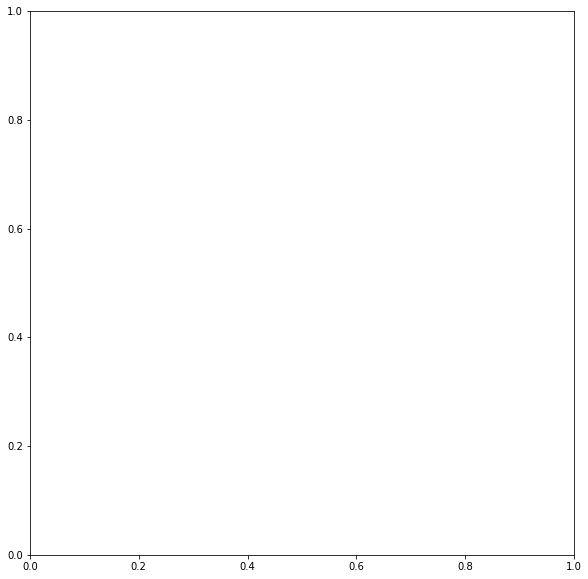

In [49]:
from utils import show_mask, show_mask_2

for i in range(len(test_dataset_vis)):
    if i > 10:
        break
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]

    gt_mask = gt_mask.squeeze()
    pr_mask = predict_mask(image, best_model)

    i = show_mask_2(image_vis, pr_mask)